# Install Julia on Google Colab
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia (the Jupyter kernel for Julia) and other packages. You can update `JULIA_VERSION` and the other parameters, if you know what you're doing. Installation takes 2-3 minutes.
3. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the _Checking the Installation_ section.

* _Note_: If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2 and 3.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.4.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools PyCall PyPlot"
JULIA_PACKAGES_IF_GPU="CUDA"
JULIA_NUM_THREADS=4
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"'
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.4.2 on the current Colab Runtime...
2020-12-05 03:39:18 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.4/julia-1.4.2-linux-x86_64.tar.gz [99093958/99093958] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
    Cloning default registries into `~/.julia`
    Cloning registry from "https://github.com/JuliaRegistries/General.git"
      Added registry `General` to `~/.julia/registries/General`
  Resolving package versions...
  Installed Artifacts ─────── v1.3.0
  Installed VersionParsing ── v1.2.0
  Installed MbedTLS_jll ───── v2.16.8+1
  Installed ZeroMQ_jll ────── v4.3.2+5
  Installed SoftGlobalScope ─ v1.1.0
  Installed Parsers ───────── v1.0.13
  Installed IJulia ────────── v1.23.1
  Installed JLLWrappers ───── v1.1.3
  Installed JSON ──────────── v0.21.1
  Installed Conda ─────────── v1.5.0
  Installed ZMQ ───────────── v1.2.1
  Installed MbedTLS ───────── v1.0.3
######################################################################## 100.

# Linear Regression with Flux

In [ ]:
using Pkg
Pkg.add(["Flux","Distributions","Plots","RDatasets","CSV","DataFrames","MLJ","DecisionTree","MLJModels","MLJScikitLearnInterface","PrettyPrinting","StableRNGs"])

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


  Resolving package versions...
  Installed DecisionTree ───────────────── v0.10.10
  Installed MLJ ────────────────────────── v0.15.0
  Installed DataFrames ─────────────────── v0.22.1
  Installed Flux ───────────────────────── v0.11.1
  Installed Distributions ──────────────── v0.24.6
  Installed Plots ──────────────────────── v1.6.12
  Installed StableRNGs ─────────────────── v1.0.0
  Installed PrettyPrinting ─────────────── v0.2.0
  Installed FFMPEG_jll ─────────────────── v4.3.1+4
  Installed MLJModels ──────────────────── v0.13.1
  Installed MLJScikitLearnInterface ────── v0.1.7
  Installed JLSO ───────────────────────── v2.4.0
  Installed RDatasets ──────────────────── v0.7.3
  Installed Mocking ────────────────────── v0.7.1
  Installed OpenSpecFun_jll ────────────── v0.5.3+4
  Installed ChainRulesTestUtils ────────── v0.5.4
  Installed IniFile ────────────────────── v0.5.0
  Installed TableTraits ────────────────── v1.0.0
  Installed RData ──────────────────────── v0.7.3
  Inst

In [ ]:
# Lets bring in all the modules required 
using Flux
using Distributions
using Plots

**Chain rule for the Back Prop **
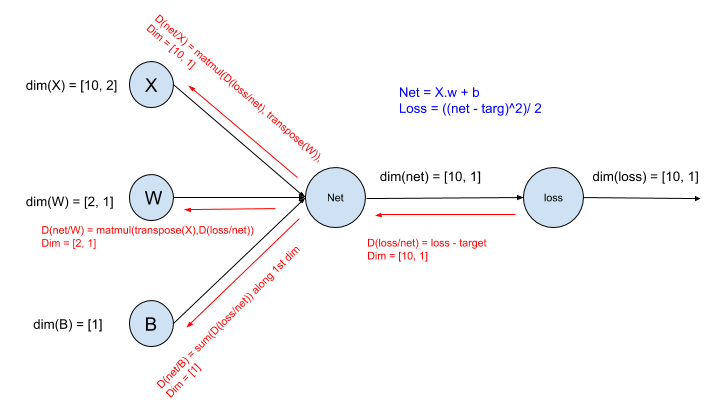


In [ ]:
# Lets create a synthetic dataset of 100 datapoints 
n=100
x = ones(n,2)
# sample x from a uniform distribution from range (-1,1)
x[:,1] = rand(Distributions.Uniform(-1.,1), 100);

In [ ]:
# We will be creating the dataset of type f(x) = 3x + 2
a = [3.0, 2.0]                   # a is a vector of weights
y = x * a + rand(n);              # x * a will create the required dataset but lets add rand to input some noise, NOTE - rand returns a number from 0 to 1

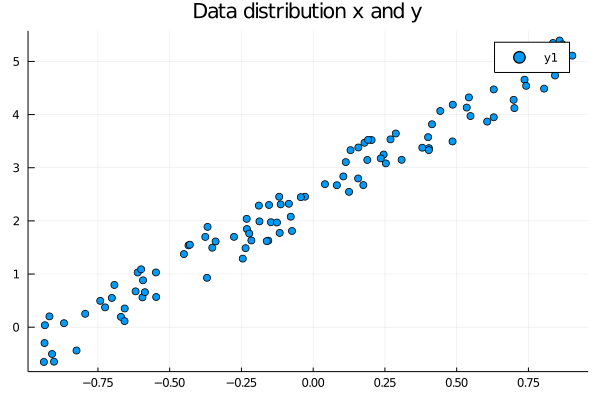

In [ ]:
# Lets plot our dataset to see how it looks
gr()
plot(x[:,1], y, seriestype = :scatter, title = "Data distribution x and y")

In [ ]:
# Lets define a loss function for our regression problem 
function mean_squared_loss(y_hat, y)
  mean(sum((y .- y_hat).^2))
end

mean_squared_loss (generic function with 1 method)

In [ ]:
#= Now that we have created the dataset, lets start with random weights and try to figure out 
what were the true weigts were =# 
a = rand(2)                              # assign random weight
y_hat = x*a                              # compute predictions
mean_squared_loss(y_hat, y)              # calculate loss

656.6714072788403

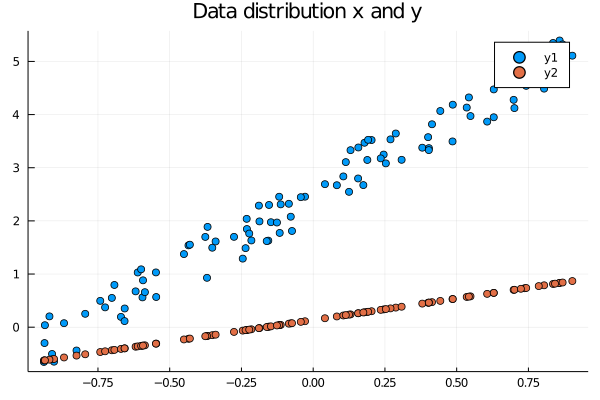

In [ ]:
# That was quite high 
# lets plot and heck how it looks
plot!(x[:,1], y_hat, seriestype = :scatter)

In [ ]:
# from the plot above its evident that model is noway near that fits well
# Let create a function which updates the weights every iteration
function update(epoch, a, lr)
    y_hat = x * a                                                              # Predictions, model
    if epoch % 10 == 0                                                         # Print the loss every 10 epochs
        println(mean_squared_loss(y_hat, y))
    end
    grads = gradient(() -> mean_squared_loss(x*a, y), Flux.params(a))          # Here Flux.params will get the gradient of weights w.r.t loss
    a = a .- lr*grads[a]                                                       # Update your weights in the direction oppsoite to gradient , optimizer
    return a                                                          
end

update (generic function with 2 methods)

In [ ]:
lr = 0.001
a = [-1.0,1.0]
for epoch in 1:100
    a = update(epoch, a, lr)
end

171.49805444876782
59.589486197277175
24.522237541316713
13.251181423898021
9.625204572518296
8.458664720882904
8.083368116406355
7.962628523216847
7.92378444839443
7.911287618572253


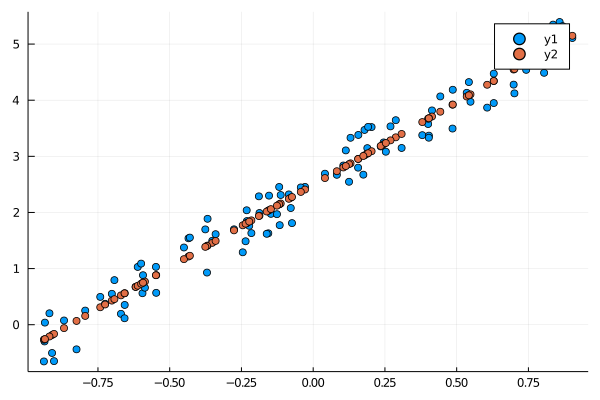

In [ ]:
# Let plot a new graph to see how well is our model doing
scatter(x[:,1], y)
scatter!(x[:,1], x*a)

In [ ]:
# Lets look at our weights, Looks like they are pretty close to [3, 2] which was the original weights we had used to create the synthetic dataset
a

2-element Array{Float64,1}:
 2.9405514628046845
 2.4923971649070067

# Polynomial Regression, Under fitting and Over fitting (Flux)

In [ ]:
# The above principles can be applied to polynomial regression and multi variable regression
# Create synthetic dataset with polynomial degree of 2 of around 40 datapoints
n=20
x = ones(n,2)
x[:,1] = rand(Distributions.Uniform(-1.,1), n);
# We will create f(x) = 2x -4x^2 + 1 + added noise 
y = (2 .* x[:,1]) + (-4 .* (x[:,1] .^ 2)) + (1 .* x[:,2]) + rand(n);       

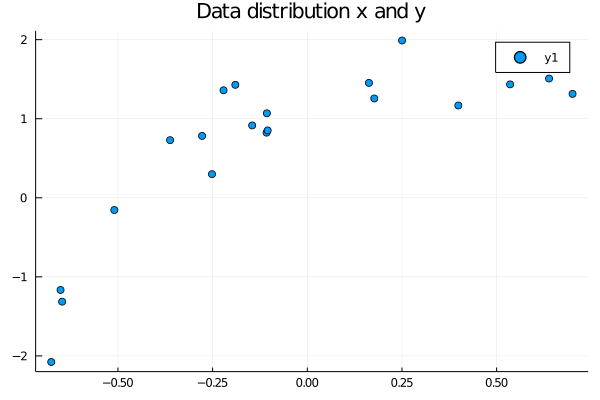

In [ ]:
# Lets have a look at it 
plot(x[:,1], y, seriestype = :scatter, title = "Data distribution x and y")

In [ ]:
# Lets start by creating a loss function as simple regression example
function mean_squared_loss(y_hat, y)
  mean(sum((y .- y_hat).^2))
end

mean_squared_loss (generic function with 1 method)

In [ ]:
# update x 
# todo find a function to do this in place
temp = ones(n,3)
temp[:,1] = x[:,1]
temp[:,2] = (x[:,1] .^ 2)
temp[:,3] = x[:,2]
x = temp

20×3 Array{Float64,2}:
  0.176885  0.0312883  1.0
 -0.189999  0.0360996  1.0
 -0.651531  0.424492   1.0
 -0.647301  0.418999   1.0
 -0.107529  0.0115625  1.0
  0.700453  0.490635   1.0
 -0.676066  0.457066   1.0
  0.398839  0.159072   1.0
 -0.277824  0.0771859  1.0
 -0.25161   0.0633075  1.0
  0.162727  0.02648    1.0
  0.638405  0.407561   1.0
 -0.104667  0.0109552  1.0
 -0.362255  0.131229   1.0
  0.53559   0.286857   1.0
 -0.509499  0.25959    1.0
 -0.145505  0.0211716  1.0
  0.250318  0.0626591  1.0
 -0.106685  0.0113818  1.0
 -0.221138  0.048902   1.0

In [ ]:
#= Now that we have created the dataset, lets start with random weights and try to figure out 
what were the true weigts were =# 
a = rand(Distributions.Uniform(-1.,1), 3)                              # assign random weight                                   # update x for easier multiplication tot get y_hat
y_hat = x * a                                                          # compute predictions
mean_squared_loss(y_hat, y)                                            # calculate loss

23.968448685974227

In [ ]:
# Lets see what a( weights) looks like and create a function for plotting it
@show a

a = [0.43727806412534953, 0.852588389151105, 0.14237224420526573]


3-element Array{Float64,1}:
 0.43727806412534953
 0.852588389151105
 0.14237224420526573

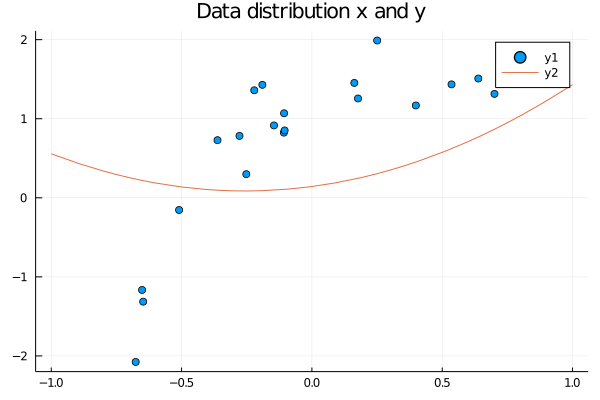

In [ ]:
# Create a simple function with  the above weights
g(var) = (a[1] * var) +  (a[2] * (var ^ 2)) + (a[3])        
# plot a line graph
plot(x[:,1], y, seriestype = :scatter, title = "Data distribution x and y")
plot!(g,-1,1)                                                      # doesnt look like a good fit

In [ ]:
# Let create a function which updates the weights every iteration, same as before
function update(epoch, a, lr)
    y_hat = x * a                                                              # Predictions
    if epoch % 10 == 0                                                         # Print the loss every 10 epochs
        println(mean_squared_loss(y_hat, y))
    end
    grads = gradient(() -> mean_squared_loss(x*a, y), Flux.params(a))          # Here Flux.params will get the gradient of weights w.r.t loss
    a = a .- lr*grads[a]                                                       # Update your weights in the direction oppsoite to gradient 
    return a                                                          
end

update (generic function with 2 methods)

In [ ]:
lr = 0.001
for epoch in 1:500
    a = update(epoch, a, lr)
end

21.271724279360072
19.357764284665016
18.007681738105806
16.95220433997158
16.069564995192653
15.30203487870376
14.6200298694604
14.006632006010971
13.45087697034564
12.94481034019266
12.482168264421885
12.05776189872944
11.667169869471397
11.306568272578186
10.972624410079243
10.66242202146763
10.37340366283318
10.103323626445444
9.850208169525661
9.612321318459227
9.388135200363388
9.17630418598925
8.975642303610257
8.785103487999592
8.603764298871221
8.430808795594277
8.26551529699283
8.107244790136228
7.955430782023395
7.809570414012452
7.669216681425416
7.533971620461916
7.403480341776978
7.277425805139771
7.155524242767685
7.0375211504616
6.923187775759564
6.812318041158004
6.704725848179083
6.600242714827746
6.498715704902726
6.400005612807587
6.303985372043148
6.210538659531893
6.119558671398949
6.030947048874673
5.944612935644993
5.86047215030465
5.778446459606856
5.698462939986993


In [ ]:
# check the updated weights
@show a

a = [1.90144454660215, -0.9172344056711312, 0.9603629214725519]


3-element Array{Float64,1}:
  1.90144454660215
 -0.9172344056711312
  0.9603629214725519

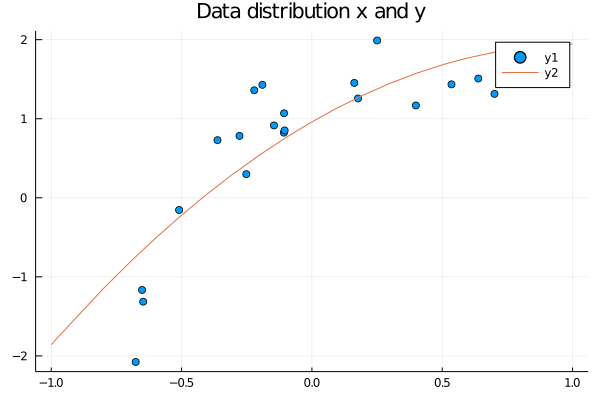

In [ ]:
# Lets have a look at it 
plot(x[:,1], y, seriestype = :scatter, title = "Data distribution x and y")
g(var) = (a[1] * var) +  (a[2] * (var ^ 2)) + (a[3])
plot!(g,-1,1)        

## Under fitting and Overfitting

In [ ]:
# Lets take a look at what happens if we try to make the model simple or more complex with the same dataset as above
# simple model with f(x) = mx + c
x_under = ones(n,2)
x_under[:,1] = x[:,1]
# complex model with f(x) = ax + bx^2 + cx^3 + dx^4 + e, where alphabets are constant
x_over = ones(n,10)
for i in 1:9
    x_over[:,i] = x[:,1] .^ i
end

In [ ]:
# lets override our function to take some additional parameters
function update(epoch, a, lr, x)
    y_hat = x * a                                                              # Predictions
    if epoch % 10 == 0                                                         # Print the loss every 10 epochs
        println(mean_squared_loss(y_hat, y))
    end
    grads = gradient(() -> mean_squared_loss(x*a, y), Flux.params(a))          # Here Flux.params will get the gradient of weights w.r.t loss
    a = a .- lr*grads[a]                                                       # Update your weights in the direction oppsoite to gradient 
    return a                                                          
end

update (generic function with 2 methods)

In [ ]:
# for x_under
lr = 0.001
a = rand(Distributions.Uniform(-1.,1), 2)
for epoch in 1:500
    a = update(epoch, a, lr, x_under)
end

42.27708062784014
30.823489335148878
24.87207047218885
21.454893196592437
19.252208574210584
17.671042248380317
16.439665469105016
15.429017717803422
14.573984712891097
13.838621844751477
13.200726795469421
12.644939664964337
12.159608353648093
11.735322618444677
11.36419301025983
11.039466980364269
10.75530162475217
10.50661261600449
10.288963025079214
10.098475270813049
9.931758127396547
9.785844630617484
9.658138519881074
9.546367709695408
9.448543719403192
9.362926232317191
9.287992106658725
9.22240826628419
9.165007979813266
9.114770102157717
9.070800907396444
9.03231818903013
8.998637344419757
8.969159195702947
8.943359330457671
8.920778772456195
8.901015816530327
8.883718882285732
8.868580259531345
8.855330634154775
8.843734297059292
8.833584950929817
8.824702040230687
8.816927539146363
8.810123140322888
8.804167794398209
8.79895555654992
8.794393701750758
8.790401075202556
8.786906648603019


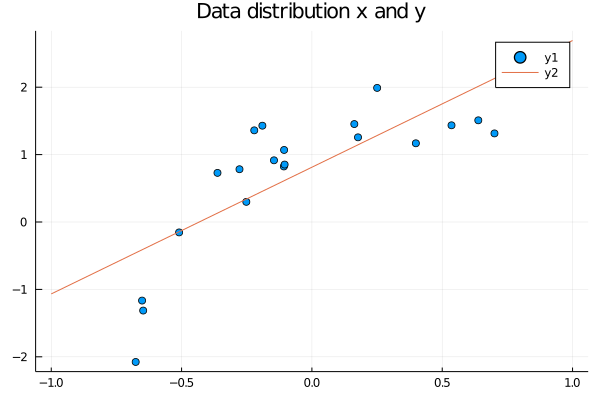

In [ ]:
# U can immediately notice that the loss is much higher than before
# lets plot it
# Lets have a look at it 
plot(x[:,1], y, seriestype = :scatter, title = "Data distribution x and y")
g_under(var) = (a[1] * var) +  a[2] 
plot!(g_under,-1,1)                                                            # No way near a good fit

In [ ]:
# for x_over
lr = 0.001
a = rand(Distributions.Uniform(-1.,1), 10)
for epoch in 1:500
    a = update(epoch, a, lr, x_over)
end

42.3419013164085
26.44646768119956
18.91407832114938
15.051024114852137
12.838957339213733
11.404137693192768
10.36335458626381
9.544327570966688
8.866084391542545
8.287696087466799
7.786232810694211
7.347221250277673
6.9604597314190935
6.618137156412525
6.313949252631083
6.04265219858636
5.799812852608114
5.581651353812842
5.384930383055011
5.206870535108378
5.045082146634949
4.897508702105857
4.762379087590192
4.638166971598539
4.523556102108493
4.417410594356808
4.318749463942304
4.226724786432298
4.140602961466318
4.059748637331692
3.983610916719659
3.9117115189787515
3.84363462063255
3.7790181356072114
3.7175462305794986
3.6589428999618088
3.602966449995591
3.549404762825854
3.498071229785986
3.448801258867845
3.4014492748588796
3.355886142214517
3.3119969506731683
3.2696791121474456
3.2288407247391993
3.1893991660002587
3.1512798829431503
3.1144153509232244
3.0787441774744755
3.044210330579169


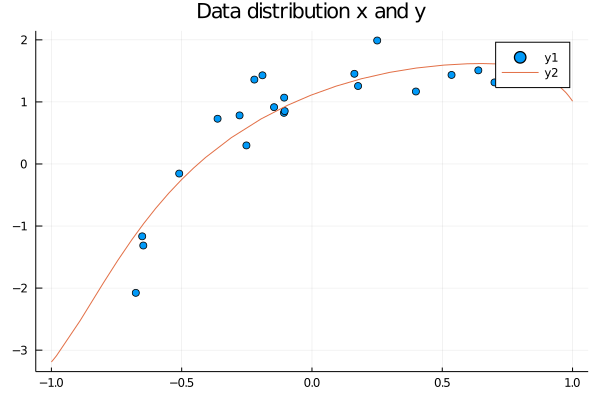

In [ ]:
# With a lil more epochs we can bring loss really down
# lets plot it
# Lets have a look at it 
plot(x[:,1], y, seriestype = :scatter, title = "Data distribution x and y")
function g_over(var)
    sum = 0 
    for i in 1:9
        sum += (a[i] * (var ^ i))
    end
    sum += a[10]
    return sum
end
plot!(g_over,-1,1)   

# Linear Regression (MLJ)

In [ ]:
# Lets bring in all the modules required 
using Distributions
using Plots
using DataFrames
using MLJ
using StableRNGs
using PrettyPrinting

In [ ]:
import RDatasets: dataset
data = dataset("datasets", "longley")

16×8 DataFrame
 Row │ Year   GNPDeflator  GNP      Unemployed  ArmedForces  Population  Year_ ⋯
     │ Int64  Float64      Float64  Float64     Float64      Float64     Int64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  1947         83.0  234.289       235.6        159.0     107.608    194 ⋯
   2 │  1948         88.5  259.426       232.5        145.6     108.632    194
   3 │  1949         88.2  258.054       368.2        161.6     109.773    194
   4 │  1950         89.5  284.599       335.1        165.0     110.929    195
   5 │  1951         96.2  328.975       209.9        309.9     112.075    195 ⋯
   6 │  1952         98.1  346.999       193.2        359.4     113.27     195
   7 │  1953         99.0  365.385       187.0        354.7     115.094    195
   8 │  1954        100.0  363.112       357.8        335.0     116.219    195
   9 │  1955        101.2  397.469       290.4        304.8     117.388    195 ⋯
  10 │  1956        104.6  419.18        282.2        285.7     118.734    195
  11 │  1957        108.4  442.769       293.6        279.8     120.445    195
  12 │  1958        110.8  444.546       468.1        263.7     121.95     195
  13 │  1959        112.6  482.704       381.3        255.2     123.366    195 ⋯
  14 │  1960        114.2  502.601       393.1        251.4     125.368    196
  15 │  1961        115.7  518.173       480.6        257.2     127.852    196
  16 │  1962        116.9  554.894       400.7        282.7     130.081    196
                                                               2 columns omitted

In [ ]:
schema(data)

┌─────────────┬─────────┬────────────┐
│ _.names     │ _.types │ _.scitypes │
├─────────────┼─────────┼────────────┤
│ Year        │ Int64   │ Count      │
│ GNPDeflator │ Float64 │ Continuous │
│ GNP         │ Float64 │ Continuous │
│ Unemployed  │ Float64 │ Continuous │
│ ArmedForces │ Float64 │ Continuous │
│ Population  │ Float64 │ Continuous │
│ Year_1      │ Int64   │ Count      │
│ Employed    │ Float64 │ Continuous │
└─────────────┴─────────┴────────────┘
_.nrows = 16


In [ ]:
y, x = unpack(data, ==(:Employed), colname->true)

([60.323, 61.122, 60.171, 61.187, 63.221, 63.639, 64.989, 63.761, 66.019, 67.857, 68.169, 66.513, 68.655, 69.564, 69.331, 70.551], 16×7 DataFrame
 Row │ Year   GNPDeflator  GNP      Unemployed  ArmedForces  Population  Year_ ⋯
     │ Int64  Float64      Float64  Float64     Float64      Float64     Int64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  1947         83.0  234.289       235.6        159.0     107.608    194 ⋯
   2 │  1948         88.5  259.426       232.5        145.6     108.632    194
   3 │  1949         88.2  258.054       368.2        161.6     109.773    194
   4 │  1950         89.5  284.599       335.1        165.0     110.929    195
   5 │  1951         96.2  328.975       209.9        309.9     112.075    195 ⋯
   6 │  1952         98.1  346.999       193.2        359.4     113.27     195
   7 │  1953         99.0  365.385       187.0        354.7     115.094    195
   8 │  1954        100.0  363.112       357.8        

In [ ]:
Pkg.add("MLJLinearModels")

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


In [ ]:
using MLJLinearModels
@load LinearRegressor pkg=MLJLinearModels
@load RidgeRegressor pkg=MLJLinearModels
@load LassoRegressor pkg=MLJLinearModels

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ MLJModels /root/.julia/packages/MLJModels/p4SQ5/src/loading.jl:132
┌ Info: Model code for LinearRegressor already loaded
└ @ MLJModels /root/.julia/packages/MLJModels/p4SQ5/src/loading.jl:145


(LinearRegressor)() ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ MLJModels /root/.julia/packages/MLJModels/p4SQ5/src/loading.jl:132
┌ Info: Model code for RidgeRegressor already loaded
└ @ MLJModels /root/.julia/packages/MLJModels/p4SQ5/src/loading.jl:145


(RidgeRegressor)() ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ MLJModels /root/.julia/packages/MLJModels/p4SQ5/src/loading.jl:132
┌ Info: Model code for LassoRegressor already loaded
└ @ MLJModels /root/.julia/packages/MLJModels/p4SQ5/src/loading.jl:145


(LassoRegressor)() ✔


LassoRegressor(
    lambda = 1.0,
    fit_intercept = true,
    penalize_intercept = false,
    solver = nothing) @422

In [ ]:
lm = LinearRegressor()
linear_model = machine(lm, x, y)

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=LinearRegressor @976`:
│ scitype(X) = Table{Union{AbstractArray{ScientificTypes.Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{#s24} where #s24<:(AbstractArray{#s23,1} where #s23<:ScientificTypes.Continuous).
└ @ MLJBase /root/.julia/packages/MLJBase/fYEbE/src/machines.jl:77


Machine{LinearRegressor} @516 trained 0 times.
  args: 
    1:	Source @092 ⏎ `Table{Union{AbstractArray{ScientificTypes.Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @366 ⏎ `AbstractArray{ScientificTypes.Continuous,1}`


In [ ]:
?LinearRegressor

search: LinearRegressor LinearRegression GeneralizedLinearRegression



Standard linear regression model.

## Parameters

  * `fit_intercept` (Bool): whether to fit the intercept or not.
  * `solver`: type of solver to use (if `nothing` the default is used). The           solver is Cholesky by default but can be Conjugate-Gradient as           well. See `?Analytical` for more information.


In [ ]:
rng = StableRNG(566)
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=rng)
fit!(linear_model, rows=train)

┌ Info: Training Machine{LinearRegressor} @516.
└ @ MLJBase /root/.julia/packages/MLJBase/fYEbE/src/machines.jl:319


Machine{LinearRegressor} @516 trained 1 time.
  args: 
    1:	Source @092 ⏎ `Table{Union{AbstractArray{ScientificTypes.Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @366 ⏎ `AbstractArray{ScientificTypes.Continuous,1}`


In [ ]:
y_hat = predict(linear_model, rows=test)

5-element Array{Float64,1}:
 61.17168783804664
 69.58695838464519
 59.640822581000975
 68.2116403302798
 64.12784952850507

In [ ]:
fitted_params(linear_model) |> pprint

(coefs = [:Year => 1.1342674821935363,
          :GNPDeflator => 0.08517005719445914,
          :GNP => -0.03889234801353752,
          :Unemployed => -0.02094719804104866,
          :ArmedForces => -0.0110166943351412,
          :Population => -0.43069078611678685,
          :Year_1 => 1.1342667592644422],
 intercept = -4302.1198225908665)

In [ ]:
cv=CV(nfolds=3)
evaluate!(linear_model,resampling=cv, measure=l2, verbosity=0)

┌────────────────────────────────┬───────────────┬─────────────────────┐
│ _.measure                      │ _.measurement │ _.per_fold          │
├────────────────────────────────┼───────────────┼─────────────────────┤
│ \eLPLoss{Int64} @555\e │ 12.3          │ [34.2, 0.442, 2.25] │
└────────────────────────────────┴───────────────┴─────────────────────┘
_.per_observation = [[[60.8, 55.3, ..., 0.16], [0.135, 0.0748, ..., 0.285], [0.239, 0.842, ..., 6.85]]]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


# Decision Trees

In [ ]:
# Lets bring in all the modules required 
using Flux
using Distributions
using Plots
using DataFrames
using MLJ
using StableRNGs
using PrettyPrinting

In [ ]:
# We will be using MLJ, which acts a common interface between Julia and most of the ML Libraries in Julia
# Lets explore a sample dataset from the built in library
import RDatasets: dataset
smarket = dataset("ISLR", "Smarket")
@show size(smarket)                                                            # gives the dimension of the Dataframe
@show names(smarket)                                                           # gives the columns of the Dataframe

size(smarket) = (1250, 9)
names(smarket) = ["Year", "Lag1", "Lag2", "Lag3", "Lag4", "Lag5", "Volume", "Today", "Direction"]


9-element Array{String,1}:
 "Year"
 "Lag1"
 "Lag2"
 "Lag3"
 "Lag4"
 "Lag5"
 "Volume"
 "Today"
 "Direction"

In [ ]:
# analogous to head in python 
first(smarket, 10) |> pretty

┌────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────────────────────────┐
│ Year       │ Lag1       │ Lag2       │ Lag3       │ Lag4       │ Lag5       │ Volume     │ Today      │ Direction                      │
│ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │ CategoricalValue{String,UInt8} │
│ Continuous │ Continuous │ Continuous │ Continuous │ Continuous │ Continuous │ Continuous │ Continuous │ Multiclass{2}                  │
├────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────────────────────────┤
│ 2001.0     │ 0.381      │ -0.192     │ -2.624     │ -1.055     │ 5.01       │ 1.1913     │ 0.959      │ Up                             │
│ 2001.0     │ 0.959      │ 0.381      │ -0.192     │ -2.624     │ -1.055     │ 1.2965     │ 1.032      │ Up                             │
│ 2001.0     │ 1.032      │

In [ ]:
# We can also index 
smarket[1:10, [:Lag1, :Direction]]

10×2 DataFrame
 Row │ Lag1     Direction 
     │ Float64  Cat…      
─────┼────────────────────
   1 │   0.381  Up
   2 │   0.959  Up
   3 │   1.032  Down
   4 │  -0.623  Up
   5 │   0.614  Up
   6 │   0.213  Up
   7 │   1.392  Down
   8 │  -0.403  Up
   9 │   0.027  Up
  10 │   1.303  Up

In [ ]:
# Describe is a simple function to understand the general trend of the data
describe(smarket)

9×7 DataFrame
 Row │ variable   mean       min      median   max      nmissing  eltype       ⋯
     │ Symbol     Union…     Any      Union…   Any      Int64     DataType     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Year       2003.02    2001.0   2003.0   2005.0          0  Float64      ⋯
   2 │ Lag1       0.0038344  -4.922   0.039    5.733           0  Float64
   3 │ Lag2       0.0039192  -4.922   0.039    5.733           0  Float64
   4 │ Lag3       0.001716   -4.922   0.0385   5.733           0  Float64
   5 │ Lag4       0.001636   -4.922   0.0385   5.733           0  Float64      ⋯
   6 │ Lag5       0.0056096  -4.922   0.0385   5.733           0  Float64
   7 │ Volume     1.4783     0.35607  1.42295  3.15247         0  Float64
   8 │ Today      0.0031384  -4.922   0.0385   5.733           0  Float64
   9 │ Direction             Down              Up              0  CategoricalV ⋯
                                                                1 column omitted

In [ ]:
# From the above table we can eltype as the "Machine type" i.e.. it represents the data how it is stored in the Machine
# MLJ offers an another types known as the scientific type, which means how the data should be interpreted 
# For example the target variable might be loaded in the machine as "INT", however it should be really considered as a categorical value
# For more details refer https://alan-turing-institute.github.io/DataScienceTutorials.jl/data/scitype/

In [ ]:
?unpack

search: unpack



```
t1, t2, ...., tk = unnpack(table, f1, f2, ... fk;
                           wrap_singles=false,
                           shuffle=false,
                           rng::Union{AbstractRNG,Int}=nothing)
```

)

Split any Tables.jl compatible `table` into smaller tables (or vectors) `t1, t2, ..., tk` by making selections *without replacement* from the column names defined by the filters `f1`, `f2`, ..., `fk`. A *filter* is any object `f` such that `f(name)` is `true` or `false` for each column `name::Symbol` of `table`.

Whenever a returned table contains a single column, it is converted to a vector unless `wrap_singles=true`.

Scientific type conversions can be optionally specified (note semicolon):

```
unpack(table, t...; wrap_singles=false, col1=>scitype1, col2=>scitype2, ... )
```

If `shuffle=true` then the rows of `table` are first shuffled, using the global RNG, unless `rng` is specified; if `rng` is an integer, it specifies the seed of an automatically generated Mersenne twister. If `rng` is specified then `shuffle=true` is implicit.

### Example

```
julia> table = DataFrame(x=[1,2], y=['a', 'b'], z=[10.0, 20.0], w=["A", "B"])
julia> Z, XY = unpack(table, ==(:z), !=(:w);
               :x=>Continuous, :y=>Multiclass)
julia> XY
2×2 DataFrame
│ Row │ x       │ y            │
│     │ Float64 │ Categorical… │
├─────┼─────────┼──────────────┤
│ 1   │ 1.0     │ 'a'          │
│ 2   │ 2.0     │ 'b'          │

julia> Z
2-element Array{Float64,1}:
 10.0
 20.0
```


In [ ]:
# Lets split the data as inputs and target
target, input = unpack(smarket, ==(:Direction), colname -> true)

(CategoricalArrays.CategoricalValue{String,UInt8}["Up", "Up", "Down", "Up", "Up", "Up", "Down", "Up", "Up", "Up"  …  "Down", "Down", "Down", "Up", "Up", "Up", "Down", "Up", "Down", "Down"], 1250×8 DataFrame
  Row │ Year     Lag1     Lag2     Lag3     Lag4     Lag5     Volume   Today   ⋯
      │ Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64 ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │  2001.0    0.381   -0.192   -2.624   -1.055    5.01   1.1913     0.959 ⋯
    2 │  2001.0    0.959    0.381   -0.192   -2.624   -1.055  1.2965     1.032
    3 │  2001.0    1.032    0.959    0.381   -0.192   -2.624  1.4112    -0.623
    4 │  2001.0   -0.623    1.032    0.959    0.381   -0.192  1.276      0.614
    5 │  2001.0    0.614   -0.623    1.032    0.959    0.381  1.2057     0.213 ⋯
    6 │  2001.0    0.213    0.614   -0.623    1.032    0.959  1.3491     1.392
    7 │  2001.0    1.392    0.213    0.614   -0.623    1.032  1.445     

In [ ]:
# MLJ has an API to recommend which models can be suited for the data based on the scientific types
models(matching(input, target))

43-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, ... )
 (name = BayesianQDA, package_name = ScikitLearn, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_na

In [ ]:
# schema can tell us how is the variables are currently interpreted
schema(smarket)

┌───────────┬────────────────────────────────┬───────────────┐
│ _.names   │ _.types                        │ _.scitypes    │
├───────────┼────────────────────────────────┼───────────────┤
│ Year      │ Float64                        │ Continuous    │
│ Lag1      │ Float64                        │ Continuous    │
│ Lag2      │ Float64                        │ Continuous    │
│ Lag3      │ Float64                        │ Continuous    │
│ Lag4      │ Float64                        │ Continuous    │
│ Lag5      │ Float64                        │ Continuous    │
│ Volume    │ Float64                        │ Continuous    │
│ Today     │ Float64                        │ Continuous    │
│ Direction │ CategoricalValue{String,UInt8} │ Multiclass{2} │
└───────────┴────────────────────────────────┴───────────────┘
_.nrows = 1250


In [ ]:
# Lets woek on a diff dataset
using CSV
data = DataFrame!(CSV.File("glass.csv"; header=["Id", "RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "Type"]));

┌ Warning: `DataFrame!(args...; kwargs...)` is deprecated, use `DataFrame(args...; copycols = false, kwargs...)` instead.
│   caller = top-level scope at In[200]:3
└ @ Core In[200]:3


In [ ]:
schema(data)

┌─────────┬─────────┬────────────┐
│ _.names │ _.types │ _.scitypes │
├─────────┼─────────┼────────────┤
│ Id      │ Int64   │ Count      │
│ RI      │ Float64 │ Continuous │
│ Na      │ Float64 │ Continuous │
│ Mg      │ Float64 │ Continuous │
│ Al      │ Float64 │ Continuous │
│ Si      │ Float64 │ Continuous │
│ K       │ Float64 │ Continuous │
│ Ca      │ Float64 │ Continuous │
│ Ba      │ Float64 │ Continuous │
│ Fe      │ Float64 │ Continuous │
│ Type    │ Int64   │ Count      │
└─────────┴─────────┴────────────┘
_.nrows = 214


In [ ]:
# We need to interpret "Type" column as a target variable, so lets change it 
data = coerce(data, :Type => OrderedFactor);
schema(data)

┌─────────┬────────────────────────────────┬──────────────────┐
│ _.names │ _.types                        │ _.scitypes       │
├─────────┼────────────────────────────────┼──────────────────┤
│ Id      │ Int64                          │ Count            │
│ RI      │ Float64                        │ Continuous       │
│ Na      │ Float64                        │ Continuous       │
│ Mg      │ Float64                        │ Continuous       │
│ Al      │ Float64                        │ Continuous       │
│ Si      │ Float64                        │ Continuous       │
│ K       │ Float64                        │ Continuous       │
│ Ca      │ Float64                        │ Continuous       │
│ Ba      │ Float64                        │ Continuous       │
│ Fe      │ Float64                        │ Continuous       │
│ Type    │ CategoricalValue{Int64,UInt32} │ OrderedFactor{6} │
└─────────┴────────────────────────────────┴──────────────────┘
_.nrows = 214


In [ ]:
describe(data)

11×7 DataFrame
 Row │ variable  mean       min      median   max      nmissing  eltype        ⋯
     │ Symbol    Union…     Any      Union…   Any      Int64     DataType      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Id        107.5      1        107.5    214             0  Int64         ⋯
   2 │ RI        1.51837    1.51115  1.51768  1.53393         0  Float64
   3 │ Na        13.4079    10.73    13.3     17.38           0  Float64
   4 │ Mg        2.68453    0.0      3.48     4.49            0  Float64
   5 │ Al        1.44491    0.29     1.36     3.5             0  Float64       ⋯
   6 │ Si        72.6509    69.81    72.79    75.41           0  Float64
   7 │ K         0.497056   0.0      0.555    6.21            0  Float64
   8 │ Ca        8.95696    5.43     8.6      16.19           0  Float64
   9 │ Ba        0.175047   0.0      0.0      3.15            0  Float64       ⋯
  10 │ Fe        0.0570093  0.0      0.0      0.51            0  Float64
  11 │ Type                 1                 7               0  CategoricalVa
                                                                1 column omitted

In [ ]:
y, X = unpack(data, ==(:Type), colname -> true)
X = select(data, Not(:Id));
models(matching(X,y))

5-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_name = MLJModels, ... )
 (name = RandomForestClassifier, package_name = DecisionTree, ... )

In [ ]:
Pkg.add("MLJDecisionTreeInterface")

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


In [ ]:
# DecisionTreeClassifier is the model 
# Its a struct which stores the hyperparameters of the model
# We can change the values of them by constructor DecisionTreeClassifier(max_depth=6, ..)
@load DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier()

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ MLJModels /root/.julia/packages/MLJModels/p4SQ5/src/loading.jl:132
┌ Info: Model code for DecisionTreeClassifier already loaded
└ @ MLJModels /root/.julia/packages/MLJModels/p4SQ5/src/loading.jl:145


(MLJDecisionTreeInterface.DecisionTreeClassifier)() ✔


DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = false,
    merge_purity_threshold = 1.0,
    pdf_smoothing = 0.0,
    display_depth = 5) @922

In [ ]:
decision_tree = machine(decision_tree_model, X, y)

Machine{DecisionTreeClassifier} @893 trained 0 times.
  args: 
    1:	Source @937 ⏎ `Table{Union{AbstractArray{ScientificTypes.Continuous,1}, AbstractArray{OrderedFactor{6},1}}}`
    2:	Source @448 ⏎ `AbstractArray{OrderedFactor{6},1}`


In [ ]:
# StableRNG is a random number generator
# We can get random indexes of train and test
rng = StableRNG(566)
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=rng)
test[1:3]

3-element Array{Int64,1}:
 155
  30
 118

In [ ]:
?eachindex

search: eachindex



```
eachindex(A...)
```

Create an iterable object for visiting each index of an `AbstractArray` `A` in an efficient manner. For array types that have opted into fast linear indexing (like `Array`), this is simply the range `1:length(A)`. For other array types, return a specialized Cartesian range to efficiently index into the array with indices specified for every dimension. For other iterables, including strings and dictionaries, return an iterator object supporting arbitrary index types (e.g. unevenly spaced or non-integer indices).

If you supply more than one `AbstractArray` argument, `eachindex` will create an iterable object that is fast for all arguments (a [`UnitRange`](@ref) if all inputs have fast linear indexing, a [`CartesianIndices`](@ref) otherwise). If the arrays have different sizes and/or dimensionalities, a DimensionMismatch exception will be thrown.

# Examples

```jldoctest
julia> A = [1 2; 3 4];

julia> for i in eachindex(A) # linear indexing
           println(i)
       end
1
2
3
4

julia> for i in eachindex(view(A, 1:2, 1:1)) # Cartesian indexing
           println(i)
       end
CartesianIndex(1, 1)
CartesianIndex(2, 1)
```


In [ ]:
fit!(decision_tree, rows=train)

┌ Info: Training Machine{DecisionTreeClassifier} @893.
└ @ MLJBase /root/.julia/packages/MLJBase/fYEbE/src/machines.jl:319


Machine{DecisionTreeClassifier} @893 trained 1 time.
  args: 
    1:	Source @937 ⏎ `Table{Union{AbstractArray{ScientificTypes.Continuous,1}, AbstractArray{OrderedFactor{6},1}}}`
    2:	Source @448 ⏎ `AbstractArray{OrderedFactor{6},1}`


In [ ]:
fitted_params(decision_tree) |> pprint

(tree = Decision Tree
Leaves: 6
Depth:  4,
 encoding = Dict(CategoricalArrays.CategoricalValue{Int64,UInt32} 7 (6/6) =>
                     0x00000006,
                 CategoricalArrays.CategoricalValue{Int64,UInt32} 2 (2/6) =>
                     0x00000002,
                 CategoricalArrays.CategoricalValue{Int64,UInt32} 3 (3/6) =>
                     0x00000003,
                 CategoricalArrays.CategoricalValue{Int64,UInt32} 5 (4/6) =>
                     0x00000004,
                 CategoricalArrays.CategoricalValue{Int64,UInt32} 6 (5/6) =>
                     0x00000005,
                 CategoricalArrays.CategoricalValue{Int64,UInt32} 1 (1/6) =>
                     0x00000001))

In [ ]:
y_hat = predict(decision_tree, rows=test)
@show y_hat[1]

y_hat[1] = UnivariateFinite{OrderedFactor{6}}(1=>0.0, 2=>0.0, 3=>1.0, 5=>0.0, 6=>0.0, 7=>0.0)


UnivariateFinite{OrderedFactor{6}}(1=>0.0, 2=>0.0, 3=>1.0, 5=>0.0, 6=>0.0, 7=>0.0)

In [ ]:
y_hat = predict_mode(decision_tree, rows=test)
@show y_hat[1]

y_hat[1] = CategoricalArrays.CategoricalValue{Int64,UInt32} 3 (3/6)


CategoricalArrays.CategoricalValue{Int64,UInt32} 3 (3/6)

# KNN

In [ ]:
knc = @load KNeighborsClassifier

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ MLJModels /root/.julia/packages/MLJModels/p4SQ5/src/loading.jl:132
┌ Info: Model code for KNeighborsClassifier already loaded
└ @ MLJModels /root/.julia/packages/MLJModels/p4SQ5/src/loading.jl:145


(MLJScikitLearnInterface.KNeighborsClassifier)() ✔


KNeighborsClassifier(
    n_neighbors = 5,
    weights = "uniform",
    algorithm = "auto",
    leaf_size = 30,
    p = 2,
    metric = "minkowski",
    metric_params = nothing,
    n_jobs = nothing) @267

In [ ]:
neighbour = machine(knc, X, y)

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNeighborsClassifier @267`:
│ scitype(X) = Table{Union{AbstractArray{ScientificTypes.Continuous,1}, AbstractArray{OrderedFactor{6},1}}}
│ input_scitype(model) = Table{#s24} where #s24<:(AbstractArray{#s23,1} where #s23<:ScientificTypes.Continuous).
└ @ MLJBase /root/.julia/packages/MLJBase/fYEbE/src/machines.jl:77


Machine{KNeighborsClassifier} @760 trained 0 times.
  args: 
    1:	Source @741 ⏎ `Table{Union{AbstractArray{ScientificTypes.Continuous,1}, AbstractArray{OrderedFactor{6},1}}}`
    2:	Source @103 ⏎ `AbstractArray{OrderedFactor{6},1}`


In [ ]:
fit!(neighbour, rows=train)

┌ Info: Training Machine{KNeighborsClassifier} @760.
└ @ MLJBase /root/.julia/packages/MLJBase/fYEbE/src/machines.jl:319


Machine{KNeighborsClassifier} @760 trained 1 time.
  args: 
    1:	Source @741 ⏎ `Table{Union{AbstractArray{ScientificTypes.Continuous,1}, AbstractArray{OrderedFactor{6},1}}}`
    2:	Source @103 ⏎ `AbstractArray{OrderedFactor{6},1}`


In [ ]:
y_hat = predict(neighbour, rows=test);
@show y_hat[1]

y_hat[1] = UnivariateFinite{OrderedFactor{6}}(1=>0.0, 2=>0.0, 3=>1.0, 5=>0.0, 6=>0.0, 7=>0.0)


UnivariateFinite{OrderedFactor{6}}(1=>0.0, 2=>0.0, 3=>1.0, 5=>0.0, 6=>0.0, 7=>0.0)

In [ ]:
mce = cross_entropy(y_hat, y[test]) |> mean
round(mce, digits=4)

0.0933

# Navie Bayes

In [ ]:
Pkg.add("ScikitLearn")

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


In [ ]:
nbc = @load GaussianNBClassifier pkg=ScikitLearn

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ MLJModels /root/.julia/packages/MLJModels/p4SQ5/src/loading.jl:132
┌ Info: Model code for GaussianNBClassifier already loaded
└ @ MLJModels /root/.julia/packages/MLJModels/p4SQ5/src/loading.jl:145


(MLJScikitLearnInterface.GaussianNBClassifier)() ✔


GaussianNBClassifier(
    priors = nothing,
    var_smoothing = 1.0e-9) @730

In [ ]:
navie_bayes = machine(nbc, X, y)

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=GaussianNBClassifier @730`:
│ scitype(X) = Table{Union{AbstractArray{ScientificTypes.Continuous,1}, AbstractArray{OrderedFactor{6},1}}}
│ input_scitype(model) = Table{#s24} where #s24<:(AbstractArray{#s23,1} where #s23<:ScientificTypes.Continuous).
└ @ MLJBase /root/.julia/packages/MLJBase/fYEbE/src/machines.jl:77


Machine{GaussianNBClassifier} @485 trained 0 times.
  args: 
    1:	Source @161 ⏎ `Table{Union{AbstractArray{ScientificTypes.Continuous,1}, AbstractArray{OrderedFactor{6},1}}}`
    2:	Source @274 ⏎ `AbstractArray{OrderedFactor{6},1}`


In [ ]:
fit!(navie_bayes, rows=train)

┌ Info: Training Machine{GaussianNBClassifier} @485.
└ @ MLJBase /root/.julia/packages/MLJBase/fYEbE/src/machines.jl:319


Machine{GaussianNBClassifier} @485 trained 1 time.
  args: 
    1:	Source @161 ⏎ `Table{Union{AbstractArray{ScientificTypes.Continuous,1}, AbstractArray{OrderedFactor{6},1}}}`
    2:	Source @274 ⏎ `AbstractArray{OrderedFactor{6},1}`


In [ ]:
y_hat = predict(navie_bayes, rows=test);
@show y_hat[1]

y_hat[1] = UnivariateFinite{OrderedFactor{6}}(1=>0.0, 2=>0.0, 3=>1.0, 5=>0.0, 6=>0.0, 7=>0.0)


UnivariateFinite{OrderedFactor{6}}(1=>0.0, 2=>0.0, 3=>1.0, 5=>0.0, 6=>0.0, 7=>0.0)

In [ ]:
y_hat = predict_mode(navie_bayes, rows=test)
@show y_hat[1]

y_hat[1] = CategoricalArrays.CategoricalValue{Int64,UInt32} 3 (3/6)


CategoricalArrays.CategoricalValue{Int64,UInt32} 3 (3/6)

# Unit 4 : Unsupervised ML

In [ ]:
using Pkg

In [ ]:
Pkg.add(["RDatasets","MultivariateStats","Clustering","Plots","CSV","DataFrames","StatsBase","StatsPlots","Distances"])

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]




---

## **Dimensionality Reduction- Principal Component Analysis**


---



In [ ]:
using MultivariateStats, RDatasets, Plots
plotly() # using plotly for 3D-interacive graphing

# load iris dataset
iris = dataset("datasets", "iris")

# split half to training set
Xtr = convert(Array,iris[1:2:end,1:4])'
Xtr_labels = convert(Array,iris[1:2:end,5])

# split other half to testing set
Xte = convert(Array,iris[2:2:end,1:4])'
Xte_labels = convert(Array,iris[2:2:end,5])

# suppose Xtr and Xte are training and testing data matrix,
# with each observation in a column

# train a PCA model, allowing up to 3 dimensions
M = MultivariateStats.fit(PCA, Xtr; maxoutdim=3)

# apply PCA model to testing set
Yte = MultivariateStats.transform(M, Xte)

# reconstruct testing observations (approximately)
Xr = MultivariateStats.reconstruct(M, Yte)

# group results by testing set labels for color coding
setosa = Yte[:,Xte_labels.=="setosa"]
versicolor = Yte[:,Xte_labels.=="versicolor"]
virginica = Yte[:,Xte_labels.=="virginica"]

# visualize first 3 principal components in 3D interacive plot
p = scatter(setosa[1,:],setosa[2,:],setosa[3,:],marker=:circle,linewidth=0)
scatter!(versicolor[1,:],versicolor[2,:],versicolor[3,:],marker=:circle,linewidth=0)
scatter!(virginica[1,:],virginica[2,:],virginica[3,:],marker=:circle,linewidth=0)
plot!(p,xlabel="PC1",ylabel="PC2",zlabel="PC3",size = (600, 600))

<!DOCTYPE html>
 
 
 Plots.jl

In [ ]:
using MultivariateStats, RDatasets, Plots, DataFrames, CSV;
plotly() # using plotly for 3D-interacive graphing 

# load wine dataset
wine =  DataFrame!(CSV.File("wine.csv"))

# split half to training set
Xtr = convert(Array,wine[1:2:end,2:13])'
Xtr_labels = convert(Array,wine[1:2:end,1])

# split other half to testing set
Xte = convert(Array,wine[2:2:end,2:13])'
Xte_labels = convert(Array,wine[2:2:end,1])

# suppose Xtr and Xte are training and testing data matrix,
# with each observation in a column

# train a PCA model, allowing up to 6 dimensions
M = MultivariateStats.fit(PCA, Xtr; maxoutdim=6)

# apply PCA model to testing set
Yte = MultivariateStats.transform(M, Xte)

# reconstruct testing observations (approximately)
Xr = MultivariateStats.reconstruct(M, Yte)

# group results by testing set labels for color coding
type_1_wine = Yte[:,Xte_labels.==1]
type_2_wine = Yte[:,Xte_labels.==2]
type_3_wine = Yte[:,Xte_labels.==3]

# visualize first 3 principal components in 3D interacive plot
p = scatter(type_1_wine[1,:],type_1_wine[2,:],type_1_wine[3,:],marker=:circle,linewidth=0)
scatter!(type_2_wine[1,:],type_2_wine[2,:],type_2_wine[3,:],marker=:circle,linewidth=0)
scatter!(type_3_wine[1,:],type_3_wine[2,:],type_3_wine[3,:],marker=:circle,linewidth=0)
plot!(p,xlabel="PC1",ylabel="PC2",zlabel="PC3",size = (600, 600))



┌ Warning: `DataFrame!(args...; kwargs...)` is deprecated, use `DataFrame(args...; copycols = false, kwargs...)` instead.
│   caller = top-level scope at In[216]:3
└ @ Core In[216]:3


<!DOCTYPE html>
 
 
 Plots.jl


---

## **K-Means Clustering**


---


In [ ]:
using RDatasets, Clustering, Plots
iris = dataset("datasets", "iris"); # load the data

features = collect(Matrix(iris[:, 1:4])'); # features to use for clustering
result = kmeans(features, 3); # run K-means for the 3 clusters

# plot with the point color mapped to the assigned cluster index
scatter(iris.PetalLength, iris.PetalWidth, marker_z=result.assignments, color=:lightrainbow, legend=false)


<!DOCTYPE html>
 
 
 Plots.jl

## Without Normalization

In [ ]:
using MultivariateStats, RDatasets, Plots, DataFrames, CSV
plotly() # using plotly for 3D-interacive graphing 

# load wine dataset
wine =  DataFrame!(CSV.File("./wine.csv"))

# split half to training set
Xtr = convert(Array,wine[1:2:end,2:13])'
Xtr_labels = convert(Array,wine[1:2:end,1])

# split other half to testing set
Xte = convert(Array,wine[2:2:end,2:13])'
Xte_labels = convert(Array,wine[2:2:end,1])
 
# suppose Xtr and Xte are training and testing data matrix,
# with each observation in a column

# train a PCA model, allowing up to 6 dimensions
M = MultivariateStats.fit(PCA, Xtr; maxoutdim=3)

# apply PCA model to testing set
Yte = MultivariateStats.transform(M, Xte)

# run K-means for the 3 clusters
result = kmeans(Yte, 3);

# reconstruct testing observations (approximately)
Xr = MultivariateStats.reconstruct(M, Yte)

# group results by testing set labels for color coding
type_1_wine = Yte[:,result.assignments.==1]
type_2_wine = Yte[:,result.assignments.==2]
type_3_wine = Yte[:,result.assignments.==3]

# visualize first 3 principal components in 3D interacive plot
p = scatter(type_1_wine[1,:],type_1_wine[2,:],type_1_wine[3,:],marker=:circle,linewidth=0)
scatter!(type_2_wine[1,:],type_2_wine[2,:],type_2_wine[3,:],marker=:circle,linewidth=0)
scatter!(type_3_wine[1,:],type_3_wine[2,:],type_3_wine[3,:],marker=:circle,linewidth=0)
plot!(p,xlabel="PC1",ylabel="PC2",zlabel="PC3",size = (600, 600))



┌ Warning: `DataFrame!(args...; kwargs...)` is deprecated, use `DataFrame(args...; copycols = false, kwargs...)` instead.
│   caller = top-level scope at In[219]:3
└ @ Core In[219]:3


<!DOCTYPE html>
 
 
 Plots.jl

## With Normalization




In [ ]:
using MultivariateStats, RDatasets, Plots,StatsBase, DataFrames, CSV
plotly() # using plotly for 3D-interacive graphing 

# load wine dataset
wine =  DataFrame!(CSV.File("./wine.csv"))

X = convert(Array,wine[:,2:14])

# Normalize the Dataset
dt = StatsBase.fit(UnitRangeTransform,X,dims=1)
norm_df = StatsBase.transform(dt,X)

# split half to training set
Xtr = norm_df[1:2:end,:]'
Xtr_labels = convert(Array,wine[1:2:end,1])

# split other half to testing set
Xte = norm_df[2:2:end,:]'
Xte_labels = convert(Array,wine[2:2:end,1])

# suppose Xtr and Xte are training and testing data matrix,
# with each observation in a column

# train a PCA model, allowing up to 6 dimensions
M = MultivariateStats.fit(PCA, Xtr; maxoutdim=3)

# apply PCA model to testing set
Yte = MultivariateStats.transform(M, Xte)

# run K-means for the 3 clusters
result = kmeans(Yte, 3);

# reconstruct testing observations (approximately)
Xr = MultivariateStats.reconstruct(M, Yte)

# group results by testing set labels for color coding
type_1_wine = Yte[:,result.assignments.==1]
type_2_wine = Yte[:,result.assignments.==2]
type_3_wine = Yte[:,result.assignments.==3]

# visualize first 3 principal components in 3D interacive plot
p = scatter(type_1_wine[1,:],type_1_wine[2,:],type_1_wine[3,:],marker=:circle,linewidth=0)
scatter!(type_2_wine[1,:],type_2_wine[2,:],type_2_wine[3,:],marker=:circle,linewidth=0)
scatter!(type_3_wine[1,:],type_3_wine[2,:],type_3_wine[3,:],marker=:circle,linewidth=0)
plot!(p,xlabel="PC1",ylabel="PC2",zlabel="PC3",size = (600, 600))


┌ Warning: `DataFrame!(args...; kwargs...)` is deprecated, use `DataFrame(args...; copycols = false, kwargs...)` instead.
│   caller = top-level scope at In[220]:3
└ @ Core In[220]:3


<!DOCTYPE html>
 
 
 Plots.jl


---

## **DBSCAN Clustering**


---


In [ ]:
using Clustering, Distances, DataFrames, Plots

X1 = randn(2, 200) .+ [0., 5.]
X2 = randn(2, 200) .+ [-5., 0.]
X3 = randn(2, 200) .+ [5., 0.]
X = hcat(X1, X2, X3)

df = convert(DataFrame,X')

D = pairwise(Euclidean(), X, dims=2)

R = dbscan(D, 1.0, 5)

scatter(df.x1, df.x2, marker_z=R.assignments, color=:lightrainbow, legend=false)

┌ Warning: `convert(::Type{DataFrame}, A::AbstractMatrix)` is deprecated, use `DataFrame(Tables.table(A, header = Symbol.(:x, axes(A, 2))))` instead.
│   caller = top-level scope at In[131]:7
└ @ Core In[131]:7


<!DOCTYPE html>
 
 
 Plots.jl

## Without Normalization

In [ ]:
using RDatasets, Clustering, Plots, Distances

# load the data
iris = dataset("datasets", "iris"); 

# features to use for clustering
X = collect(Matrix(iris[:, 1:4]));

D = pairwise(Euclidean(), X, dims=1)

R = dbscan(D, 0.67, 26)

# plot with the point color mapped to the assigned cluster index
scatter(iris.PetalLength, iris.PetalWidth, marker_z=R.assignments, color=:lightrainbow, legend=false)

<!DOCTYPE html>
 
 
 Plots.jl

## With Normalization

In [ ]:
using RDatasets, Clustering, Plots, Distances, StatsBase

# load the data
iris = dataset("datasets", "iris"); 

# features to use for clustering
features = collect(Matrix(iris[:, 1:4]));

# Normalize the Dataset
dt = StatsBase.fit(UnitRangeTransform, features, dims=1)
norm_feat = StatsBase.transform(dt,features)

# calculate Distance Matrix
D = pairwise(Euclidean(), norm_feat, dims=1)
D+=D'
R = dbscan(D, 0.3, 15)

# plot with the point color mapped to the assigned cluster index
scatter(iris.PetalLength, iris.PetalWidth, marker_z=R.assignments, color=:lightrainbow, legend=false)

<!DOCTYPE html>
 
 
 Plots.jl



---

## **Hierarchial Clustering**

---




In [ ]:
using Clustering,StatsPlots
D = rand(10, 10)
D += D'
hc = hclust(D, linkage=:single)
plot(hc)

<!DOCTYPE html>
 
 
 Plots.jl

## Without Normalization

In [ ]:
using Clustering,StatsPlots,CSV,Distances

# load wine dataset
wholesale =  DataFrame!(CSV.File("./Wholesale_customers_data.csv"))

X = float(convert(Array,wholesale[:,1:8]))

#calculate proximity matrix for norm_df
R = pairwise(Euclidean(), X, dims=1)

println("Symmetry of R : " , R==R')
println()

# Since R is symmetric we ignore this step
# R += R' 

hc = hclust(R, linkage=:average)
plot(hc,size = (900, 600))

Symmetry of R : true



┌ Warning: `DataFrame!(args...; kwargs...)` is deprecated, use `DataFrame(args...; copycols = false, kwargs...)` instead.
│   caller = top-level scope at In[223]:2
└ @ Core In[223]:2


<!DOCTYPE html>
 
 
 Plots.jl

## With Normalization

In [ ]:
using Clustering,StatsPlots,CSV,StatsBase,Distances

# load wine dataset
wholesale =  DataFrame!(CSV.File("./Wholesale_customers_data.csv"))

X = float(convert(Array,wholesale[:,1:8]))

# Normalize the Dataset
dt = StatsBase.fit(UnitRangeTransform,X,dims=1)
norm_df = StatsBase.transform(dt,X)

#calculate proximity matrix for norm_df
R = pairwise(Euclidean(), norm_df, dims=1)

println("Symmetry of R : " , R==R')
println()

# Since R is symmetric we ignore this step
# R += R' 

hc = hclust(R, linkage=:average)
plot(hc,size = (900, 600))


Symmetry of R : true



┌ Warning: `DataFrame!(args...; kwargs...)` is deprecated, use `DataFrame(args...; copycols = false, kwargs...)` instead.
│   caller = top-level scope at In[136]:2
└ @ Core In[136]:2


<!DOCTYPE html>
 
 
 Plots.jl